# Introduction to regression

Linear regression is one of the typical ways to compute the relationship between independent variables $X$ and a dependent variable $Y$. Linear regression relates $X$ and $Y$ with a series of weights, which we will denote with $\beta$ here.
$$
Y = X\beta
$$
We usually know the values of $X$ and $Y$ so we must use these to then solve for $\beta$. The typical way for solving a linear system of equations like this is to use ordinary least squares (OLS). OLS is the best unbiased estimator for a system of equations, but there are other types of regression that can achieve lower mean-squared errors, especially on unseen or held out data. OLS performs poorly in the following scenarios:
- The number of predictors is high compared to the number of observations! OLS also has no unique solution when there are more predictors than samples (this is referred to as an underdetermined system), therefore it will cross-validate quite poorly in this regime. 
- *Multicollinearity*. Multicollinearity occurs when independent variables in a regression model are correlated . Correlated independent variables will lead to very poor cross-validation, and in some cases OLS will not even work!

**Both of these scenarios are quite common in neural encoding models!** So we need a solution: **regularization**.

Regularized regression (which includes ridge regression and lasso regression) works by punishing solutions with large $\beta$ values, where OLS implies no restrictions on the $\beta$ values that are found. This penalization reduces model variance, which translates to improve model predictions on held out data (ie. cross-validation).

**In this notebook, we will implement OLS and ridge regression to see how their performance compares in different situations**.

 [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cheninstitutecaltech/Caltech_DATASAI_Neuroscience_23/blob/master/07_12_23_day3_decoding_encoding/code/diy_notebooks/1_Ridge_Regression.ipynb)

In [1]:
# install dependencies
!pip install gdown scikit-learn tqdm pandas matplotlib


[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

Let's import a dataset that describes the average miles per gallon (MPG) for many different cars. The displacement (the total cylinder volume of an engine), horsepower, cylinder number, and other information about the cars is also included. We will try to see how well we can predict fuel efficiency from these variables.

Visualize the data:

In [3]:
PREDICTOR_LABELS = ['cylinders','displacement','horsepower','weight','acceleration','model_year','american','japanese']
dataset = pd.read_csv('dataset.csv')
dataset.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


The shape of x is (392, 8)
The shape of y is (392,)


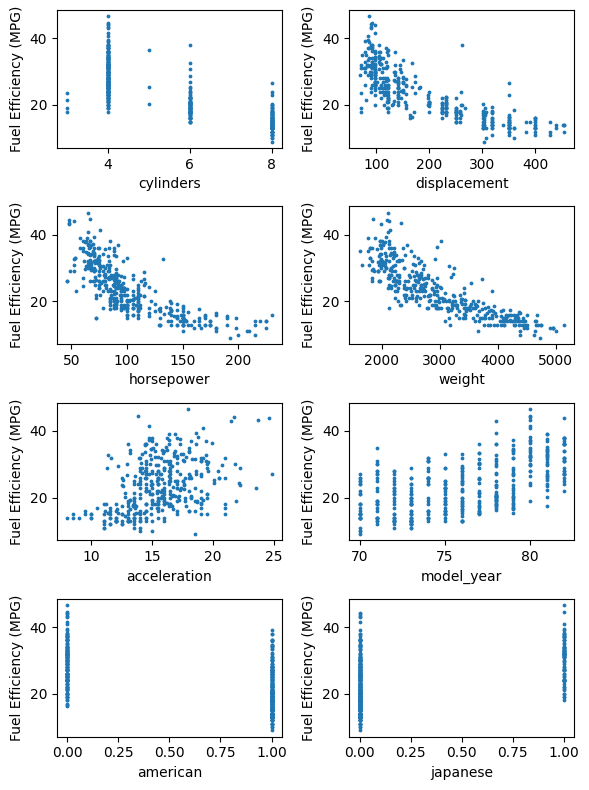

In [4]:
# Preprocess the data
dataset = dataset.dropna()
y = dataset.mpg.values
x = dataset[PREDICTOR_LABELS[:-2]].to_numpy()

is_american = (dataset.origin == 'usa').values #dummy variable
is_japanese = (dataset.origin == 'japan').values #dummy variable

x = np.vstack((x.T, is_american, is_japanese)).T
print(f'The shape of x is {x.shape}')
print(f'The shape of y is {y.shape}')

# Plot each of the regressors vs MPG
fig,axs = plt.subplots(4,2,figsize=(6,8),dpi=100)
for i,ax in enumerate(np.ravel(axs)):
    ax.scatter(x[:,i],y, s=3)
    ax.set_xlabel(PREDICTOR_LABELS[i])
    ax.set_ylabel('Fuel Efficiency (MPG)')
fig.tight_layout()

### Ordinary least squares (OLS), ridge, and lasso regression
We will use linear regression to model the relationship between each of these variables and gas mileage. 

**EXERCISE QUESTION**: Given the plots above, what do you expect the $\beta$ weights for each of these predictors will be?

**We will discuss 3 ways of modeling the relationship between the availible car info and gas mileage** 
1. OLS - used to solve a linear system of equations
2. Ridge - adds a squared penalty term to keep $\beta$'s small
3. Lasso - adds a non-squared penalty term to keep $\beta$'s small. This leads to *sparse* solutions when compared to OLS and ridge (this means that uninformative $\beta$ values get set to 0).

The goal of regression is to minimize the sum of squared errors (SSE) between the real data $y$ and the model predictions $\hat{y}$. **The major difference between these regression types how SSE is computed.**

Below are shown the different SSE formulations for OLS, ridge, and lasso regression.  
$$
SSE_{OLS} = \sum_{i=1}^{n}{(y_i - \hat{y}_i)^2}
$$
$$
SSE_{Ridge} = \sum_{i=1}^{n}{(y_i - \hat{y}_i)^2} + \alpha\sum_{j=1}^{P}{\beta_j^2}
$$
$$
SSE_{Lasso} = \sum_{i=1}^{n}{(y_i - \hat{y}_i)^2} + \lambda\sum_{j=1}^{P}{|\beta_j|}
$$
You can see that the ridge and lasso equations include an additional term that penalizes large $\beta$ values. The only difference between ridge and lasso is that ridge is squared and lasso takes the absolute value of the weights instead. In practice, this means that lasso will have sparse solutions (less informative predictors will have $\beta$ weights set to 0) while ridge regression will spread out variance across predictors, even if they are correlated. 

By minimizing the above functions, we can compute the OLS and Ridge estimators! Lasso is not included below because there is no closed-form solution.
We will not go over the complete derivation of the closed form solutions, but just know that they come from *minimizing* the above equations (ie. picking the values of $\beta$ that make the SSE as small as possible).

$$
\hat{\beta}_{OLS} = (X^TX)^{-1}X^Ty
$$
$$
\hat{\beta}_{Ridge} = (X^TX + \alpha I)^{-1}X^Ty
$$

Where $X$ is our matrix of predictors, $Y$ is our dependent variable (gas mileage), and $\alpha$ is the *ridge parameter* that determines how strong the $\beta$ weight penalty should be. $I$ is the identity matrix.

Lasso regression must be solved with other techniques such as gradient descent, so we will omit it for now. 

In this notebok we are going to implement a lot of things "by hand" to get an intuition of how the regression is done under the hood. In the next notebook we will make use of Python libraries (mostly sklearn) to do a lot of the heavy lifting for us.

### Data preprocessing normalization
It is important to properly condition $X$ and $Y$ before performing the regression. Both $X$ and $Y$ should be normalized so that the ridge penalty applies equally to all predictors. This also makes the $\beta$ weights more interpretable. Here, we will use *min-max normalization*:

$$
x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}
$$

**$Y$ must also be mean-centered**. This is really important because ridge regression does not have an intercept term (it would not make sense to include an intercept term because it would be penalized by the ridge parameter).

**In the following cell, apply min-max normalization and mean center the data**

In [5]:
# More data preprocessing
x = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y = y - np.mean(y)

### Exercise 1: Implement OLS and Ridge regression
Use the equations above to compute $\hat{\beta}_{OLS}$ and $\hat{\beta}_{Ridge}$ (beta estimates for OLS and ridge regression).

In [6]:
def ols_solver(x,y):
    """
    EXERCISE: use the equation above to compute the OLS solution for beta as a function of x and y. 
    Hint: use @ or np.matmul() for matrix multiplication  
    """
    return np.linalg.inv(x.T @ x) @ x.T @ y

def ridge_solver(x,y,alpha):
    """
    EXERCISE: use the equation above to compute the ridge solution for beta as a function of x, y and alpha.
    Hint: use @ or np.matmul() for matrix multiplication  
    """
    return np.linalg.inv(x.T @ x + alpha*np.identity(x.shape[1])) @ x.T @ y

RIDGE_ALPHA = 0

ols_betas = ols_solver(x,y)
ridge_betas = ridge_solver(x,y,RIDGE_ALPHA)

for label, ols_beta, ridge_beta in zip(PREDICTOR_LABELS, ols_betas, ridge_betas):
    print(f'OLS beta weight for {label}: {ols_beta}')
    #print(f'ridge beta weight for {label}: {ridge_beta}')

assert np.array_equiv(ols_betas,ridge_betas), "Betas not equal, change RIDGE_ALPHA so that they will become equal"

OLS beta weight for cylinders: -0.03407722627535886
OLS beta weight for displacement: 0.2015401862946056
OLS beta weight for horsepower: 0.09676076839456776
OLS beta weight for weight: -0.6981579520912886
OLS beta weight for acceleration: 0.1865453152329084
OLS beta weight for model_year: 0.27111501476079825
OLS beta weight for american: -0.055987983673881705
OLS beta weight for japanese: 0.019426596599336557


**How do the beta weights match up with what you expected from the plots above?**

### Exercise 2: Assessing model performance
Here, we will generate model predictions and implement a scoring function. A scoring function quantifies the similarity between the model predictions $\hat{y}$ and the real data $y$.

There are many ways to assess a models performance (many of them are also built into scikit-learn, which we will use later). But for now, lets practice building our own custom scoring function to evaluate the models performance. We will use the *coefficient of determination* ($R^2$), which is a useful scoring metric to evaluate many different models.

$$
R^2 = 1 - \frac{\sum_i(y_i - \hat{y}_i)^2}{\sum_i(y_i - \bar{y})^2}
$$

This the amount of fluctuation (variance) in y that the model can account for. Usually, its value ranges from 0 to 1, though values can go negative when scoring on held out (cross-validated) data.

**EXERCISE QUESTION:** What might a negative $R^2$ mean?

In [7]:
def r_squared_score(y_true, y_pred):
    """
    EXERCISE: using the above equation, implement a function that returns 
    the coefficient of determination (R^2) as a function of the true y
    values and the model predictions of y (yhat in the equation above)
    """
    ybar = np.mean(y_true)
    numerator = sum([(y_true[i] - guess)**2 for i, guess in enumerate(y_pred)])
    denominator = sum([(y - ybar)**2 for y in y_true])
    return 1 - numerator/denominator

y_pred_ols = x @ ols_betas
y_pred_ridge = x @ ridge_betas

r2_ols = r_squared_score(y,y_pred_ols)
r2_ridge = r_squared_score(y,y_pred_ridge) # if the ridge parameter (alpha) was set to zero, these scores should be equivalent

print(f'OLS R-squared: {r2_ols}')
print(f'Ridge R-squared: {r2_ridge}')

OLS R-squared: 0.8164738741138314
Ridge R-squared: 0.8164738741138314


Now let's try many different $\alpha$ values and see how ridge regression performs over these values. Larger values mean a larger penalty is applied to the beta weights. 

**Do you think ridge or OLS will perform better? Where will they be equivalent? Remember, we are not doing cross-validation yet.**

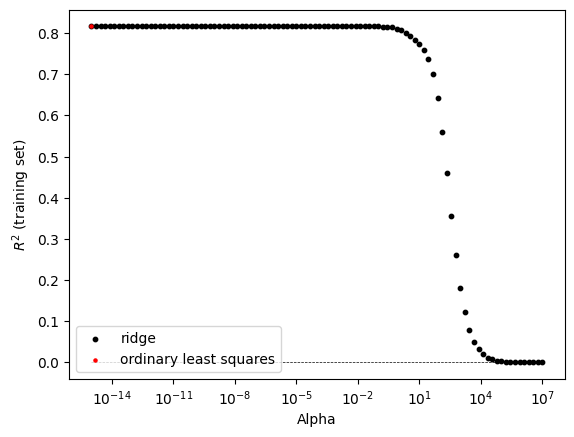

In [8]:
ALPHAS = 10**np.linspace(-15,7, 100)
betas = [ridge_solver(x,y,alpha) for alpha in ALPHAS]
scores = [r_squared_score(y, x @ beta) for beta in betas]

"""
EXERCISE: Compute the R^2 for each value in ALPHAS and add that to the numpy array called "scores".
Hint: a for loop may be helpful or you can use map() to map a function.
"""

plt.scatter(ALPHAS,scores, s=10, color='black', label='ridge')
plt.scatter(ALPHAS[0], r_squared_score(y, x @ ols_solver(x,y)), s=5, color='red',label='ordinary least squares') # plot OLS score
plt.hlines(0,ALPHAS[0],ALPHAS[-1],linestyle='--',linewidth=.5, color='black')
plt.legend()
plt.xlabel('Alpha')
plt.xscale('log')
plt.ylabel('$R^2$ (training set)')
plt.show()

### Excercise 3: Implement cross-validation

As you saw in the previous exercise, ridge regression will actually never perform better than ordinary least squares when assessing performance on training data. The power of regularization comes when generating predictions on held out data (cross-validation). When assessing model performance, it is best practice to do this on cross validated data. This ensures our model is not over-fitting and that it will be able to make reliable predictions on new data. In this toy example about fuel efficiency, we want a model that will give us a good prediction for a *new* car where the fuel efficiency is not availible. 

Here, we are going to implement k-fold cross validation. K-fold cross validation splits our data sets into k chunks. We will leave one chunk of the data out for testing (with our function `r_squared_score()`). We will train our model on the remaining data, and then go back and make predictions on the held out data.

Here's a nice visualization of 5-fold crossvalidation

![k-fold crossval figure](https://miro.medium.com/v2/resize:fit:720/1*AAwIlHM8TpAVe4l2FihNUQ.png)

https://towardsdatascience.com/cross-validation-k-fold-vs-monte-carlo-e54df2fc179b

SKLearn has several useful functions for cross-validation. We will make use of one of them here.

In [9]:
from sklearn.model_selection import KFold
N_FOLDS = 5
ALPHAS = 10**np.linspace(-15,7, 100) #try some different alpha values

def cross_val_score(x, y, n_folds, scoring_function, fitting_function, **fitting_func_kwargs):
    """
    This function takes x and y and will return a cross-validated score with "n_folds" folds
    It accepts an arbitrary scoring and fitting function and so it can be used with a vaiety of models
    and scoring metrics.
    """
    
    kf = KFold(n_splits=n_folds, shuffle=True)
    # EXERCISE: create an sklearn.model_selection.KFold object with "n_folds" folds. Name it "kf".
    # Set the shuffle parameter to True
    # SKLearn's documentation will be helpful here.
    
    train_scores = np.empty((n_folds))
    test_scores = np.empty((n_folds))
    for j, (train_index, test_index) in enumerate(kf.split(x)):
        x_train = x[train_index,:]
        x_test = x[test_index,:]
        y_train = y[train_index]
        y_test = y[test_index]

        betas = fitting_function(x=x_train,y=y_train,**fitting_func_kwargs)
        y_train_predictions = x_train @ betas
        y_test_predictions = x_test @ betas
        train_scores[j] = scoring_function(y_train, y_train_predictions)
        test_scores[j] = scoring_function(y_test, y_test_predictions)
    return np.mean(train_scores), np.mean(test_scores)

OLS test performance: 0.8047180393309479
Best ridge test performance: 0.8112017637518966


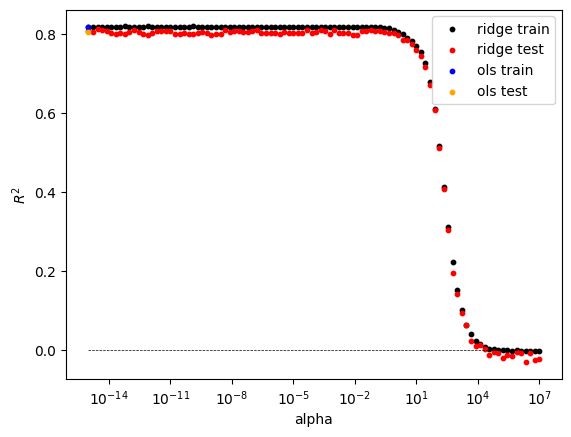

In [10]:
train_scores, test_scores = [],[]

for alpha in ALPHAS:
    betas = ridge_solver(x,y,alpha)
    train_r2, test_r2 = cross_val_score(x, y, N_FOLDS, r_squared_score, ridge_solver, alpha=alpha)
    train_scores.append(train_r2)
    test_scores.append(test_r2)

ols_train_r2, ols_test_r2 = cross_val_score(x, y, N_FOLDS, r_squared_score, ols_solver) # run OLS for comparison

plt.scatter(ALPHAS, train_scores, s=10, color='black',label='ridge train')
plt.scatter(ALPHAS, test_scores, s=10, color='red',label='ridge test')
plt.scatter(ALPHAS[0], ols_train_r2, s=10, color='blue',label='ols train')
plt.scatter(ALPHAS[0], ols_test_r2, s=10, color='orange',label='ols test')
plt.hlines(0,ALPHAS[0],ALPHAS[-1],linestyle='--',linewidth=.5, color='black')
plt.legend()
plt.xlabel('alpha')
plt.xscale('log')
plt.ylabel('$R^2$')

print(f'OLS test performance: {ols_test_r2}')
print(f'Best ridge test performance: {np.max(test_scores)}')

Look at the above plot and consider the following:
- Are the OLS or ridge models overfitting?
- is ridge regression needed in this case?

### Exercise 4: Regression with collinear regressors and underdetermined systems

In the plot above, you may have noticed that ridge regression test performance is only *slightly* better than ordinary least squares. As we introduced at the beginning of the notebook, where regularization becomes most helpful is when you have few observations relative to the number of regressors or when regressors are collinear. Neither is the case in our dataset currently, so let's manipulate our regressor matrix $X$ and compare OLS and ridge again.

In [11]:
# augment the matrix x with noisy versions of itself
random_offset = x + np.random.normal(scale=1e-5, size=x.shape) # same as x but with small random differences
random_offset_2 = x + np.random.normal(scale=1e-3, size=x.shape)
random_offset_3 = x + np.random.normal(scale=1e-7, size=x.shape)
x_augmented = np.hstack((x, random_offset, random_offset_2, random_offset_3)) # add columns to x that are nearly identical. This is an "ill-conditioned" matrix but still full rank. 

#x_augmented = np.hstack((x, x)) # This matrix exhibits multicollinearity (it is not full rank). Uncomment and see how OLS vs ridge handle this.
x_augmented = x_augmented / np.max(x_augmented, axis=0)

print(f'Shape of x is originally {x.shape}')
print(f'Shape of x with data augmentation is {x_augmented.shape}')

# now let's subsample x and y so that the number of observations is closer to the number of regressors
N_SUBSAMPLE = 50 #The number of observations to randomly grab 

subsample_indices = np.random.choice(x_augmented.shape[0], N_SUBSAMPLE, replace=False)
x_subsample = x_augmented[subsample_indices,:]
y_subsample = y[subsample_indices]
print(f'Shape of x after subsampling is {x_subsample.shape}')

Shape of x is originally (392, 8)
Shape of x with data augmentation is (392, 32)
Shape of x after subsampling is (50, 32)


OLS test R^2: -37.34410247324929
Best ridge test R^2: 0.818551229006532
Best ridge parameter (alpha): 3.5938136638046257e-06


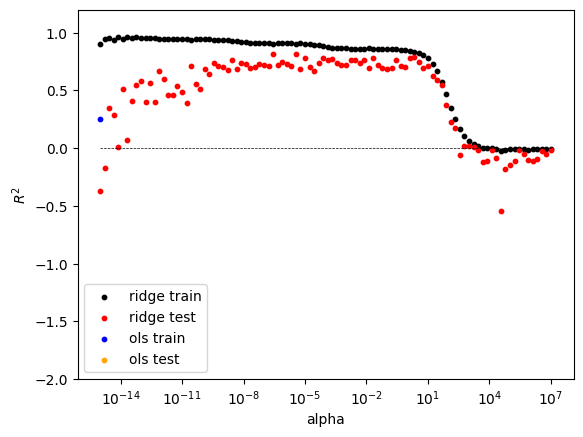

In [12]:
# now fit this new dataset (x_subsample and y_subsample)

ALPHAS = 10**np.linspace(-15,7, 100)
train_scores, test_scores = [], []
for alpha in ALPHAS:
    train_r2, test_r2 = cross_val_score(x_subsample, y_subsample, N_FOLDS, r_squared_score, ridge_solver, alpha=alpha)
    train_scores.append(train_r2)
    test_scores.append(test_r2)

ols_train_r2, ols_test_r2 = cross_val_score(x_subsample, y_subsample, N_FOLDS, r_squared_score, ols_solver) # OLS for comparison

plt.scatter(ALPHAS, train_scores, s=10, color='black',label='ridge train')
plt.scatter(ALPHAS, test_scores, s=10, color='red',label='ridge test')
plt.scatter(ALPHAS[0], ols_train_r2, s=10, color='blue',label='ols train')
plt.scatter(ALPHAS[0], ols_test_r2, s=10, color='orange',label='ols test')
plt.hlines(0,ALPHAS[0],ALPHAS[-1],linestyle='--',linewidth=.5, color='black')
plt.legend()
plt.xlabel('alpha')
plt.xscale('log')
plt.ylim(-2,1.2)
plt.ylabel('$R^2$')

print(f'OLS test R^2: {ols_test_r2}')
print(f'Best ridge test R^2: {np.max(test_scores)}')

best_ridge_alpha_value = ALPHAS[np.argmax(test_scores)]

print(f'Best ridge parameter (alpha): {best_ridge_alpha_value}')

Look at this plot after adding in more predictor variables and reducing the number of observations and consider the following:
- How are the two models performing? Are they overfitting?
- Previously, the OLS and ridge fits had similar $R^2$ values, now they look wildly different for the test data. Why do you think this is?
- See what happens when you modify `N_SUBSAMPLE`. How does this affect the results?
- Will these methods work on a collinear matrix? Try it and see what happens
- What will the $\beta$ weights look like for OLS and ridge? Will there be a unique solution for OLS and ridge?
- In your own data, how might you check to see if regressors are correlated before doing the regression?

### Up next: Selecting the proper value of alpha and fitting to neural data!
Since $\alpha$ is a model hyperparameter, it is important that the proper value is selected to get the best model performance. Cross-validating with many different alphas (what we did above) is one way to do that, but there are other ways it can be done. See Karabastos 2017, *Communications in Statistics* for another method of $\alpha$ selection. The Karabastos method is the one used in the Musall 2019 paper we discussed.

In the next notebook, we will fit an encoding model to neural data and solve it with ridge regression!